<a href="https://colab.research.google.com/github/0encodedguy0/text_summarization_plus_metrics_comparison/blob/main/Text_Summarization_(4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 𝓣𝓮𝔁𝓽 𝓢𝓾𝓶𝓶𝓪𝓻𝓲𝔃𝓪𝓽𝓲𝓸𝓷


## Экстрактивная суммаризация


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Загрузка датасета

### Экстрактивная суммаризация на основе вхождения общих слов

In [ ]:
! pip install pymorphy2
!pip install transformers
!pip install sentencepiece
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 626.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 57.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=d3cee9e810c84ef5340deeb12d54dc245ac4132f552fc89ed607a5c8c47b7196
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [ ]:
from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60964 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6793 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6369 [00:00<?, ? examples/s]

Dataset gazeta downloaded and prepared to /root/.cache/huggingface/datasets/IlyaGusev___gazeta/default/2.0.0/c329f0fc1c22ab6e43e0045ee659d0d43c647492baa2a6ab3a5ea7dac98cd552. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
!pip install -Uqq ipdb
import ipdb
%pdb on

#### Обработка данных

In [ ]:
import pandas as pd

test_text = []
test_summary = []
test_title = []
test_date = []
test_url = []
for i in range(len(dataset.data['test']['text'])):
  test_text.append(dataset.data['test']['text'][i])
  test_summary.append(dataset.data['test']['summary'][i])
  test_title.append(dataset.data['test']['title'][i])
  test_date.append(dataset.data['test']['date'][i])
  test_url.append(dataset.data['test']['url'][i])

In [ ]:
data_test = pd.DataFrame({'text': test_text, 'summary': test_summary, 'title': test_title, 'date': test_date, 'url': test_url})

In [ ]:
data_test.head()

,text,summary,title,date,url
0,На этих выходных в Берлине прошли крупные акци...,Протестующие против антикоронавирусных мер нем...,В Германии объяснили упоминание имени Путина н...,2020-09-01 00:22:59,https://www.gazeta.ru/politics/2020/08/31_a_13...
1,Высокопоставленная американская и израильская ...,"Делегации Израиля и США прилетели в ОАЭ, где о...",Делегации Израиля и США прибыли в ОАЭ для обсу...,2020-09-01 08:08:16,https://www.gazeta.ru/politics/2020/08/31_a_13...
2,Одна из руководителей Координационного совета ...,Белорусская оппозиция в лице экс-кандидата в п...,Оппозиция Белоруссии объявила о создании новой...,2020-09-01 09:21:38,https://www.gazeta.ru/politics/2020/09/01_a_13...
3,Россия считает действия ВС США во время учений...,Действия американских ВС в Эстонии во время уч...,Россия считает крайне опасными действия США на...,2020-09-01 09:33:30,https://www.gazeta.ru/army/2020/09/01/13222904...
4,С 1 сентября в России вступают в силу поправки...,Поправки в российский закон «О банкротстве» вс...,В России вступил в силу закон о внесудебном ба...,2020-09-01 09:49:24,https://www.gazeta.ru/business/2020/09/01/1322...


In [ ]:
import re
import pymorphy2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def lemmatize(text):                                 # Лемматизация слов
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)
    return res


def sentence_comparison(all_sentences):
  matrix_of_coefs = np.zeros((len(all_sentences), len(all_sentences)))
  for i in range(len(all_sentences)):
    for j in range(len(all_sentences)):
      counter = 0
      gen_length = 0
      if i < j:
        for word in all_sentences[i]:
          if word in all_sentences[j]:
            counter += 1
#            gen_length += len(word)
#        if gen_length != 0:
#          matrix_of_coefs[i][j] = (counter / gen_length)
        matrix_of_coefs[i][j] = (counter / (len(all_sentences[i]) + len(all_sentences[j])))
        matrix_of_coefs[j][i] = matrix_of_coefs[i][j]
#        else:
#          matrix_of_coefs[i][j] = 0
#          matrix_of_coefs[j][i] = matrix_of_coefs[i][j]
  ans_matrix = matrix_of_coefs.copy()
#  i = 0
#  j = 0
#  while i < len(ans_matrix[0]):
#    zeros_counter = 0
#    while j < len(ans_matrix):
#      if matrix_of_coefs[i][j] != 0:
#        i += 1
#        j = -1
#        zeros_counter = 0
#      else:
#        zeros_counter += 1
#      j += 1
#      if zeros_counter == len(matrix_of_coefs[0]) - 1:
#        ans_matrix = np.delete(ans_matrix, i, 0)
#        ans_matrix = np.delete(ans_matrix, i, 1)
#      n_rows = len(ans_matrix)
#      for l in range(n_rows):
#        _ = ans_matrix[l].pop(i)
#        i -= 1
#    i += 1
  return ans_matrix


def print_graph(matrix_of_edges, array_of_labels):
    labels_with_dot = {}
    plt.rcParams["figure.figsize"] = (8,8)
    ax = plt.gca()
    ax.set_title('Общие слова в предложениях')
    for i in range(len(array_of_labels)):
        labels_with_dot[i] = float('%.2f' % array_of_labels[i])
    printing_graph = nx.Graph(matrix_of_edges)
    nx.draw(printing_graph, pos=nx.circular_layout(printing_graph), with_labels=False, ax=ax)
    nx.draw_networkx_labels(printing_graph, pos=nx.circular_layout(printing_graph),
                            labels=labels_with_dot, font_size=5)
    plt.show()
    return 0

In [ ]:
texts = data_test['text'][:9]

In [ ]:
new_texts = []
for text in texts:
  text = re.sub(r'\([^)]*\)', '', text.as_py())
  text = text.replace("ИИ", "искусственный интеллект")
  new_texts.append(text.split("."))
print(new_texts)

[['На этих выходных в Берлине прошли крупные акции протеста против введенных для борьбы с коронавирусом ограничений', ' Демонстранты скандировали «Путин!» По словам депутата городской палаты представителей Гуннара Линдеманна , люди выкрикивали фамилию российского президента из уважения к нему', ' В комментарии РИА «Новости» немецкий политик отметил, что среди населения Германии Владимир Путин имеет хорошую репутацию', ' По его мнению, протестующие ранее пришли к российскому посольству, чтобы «привлечь внимание к условиям в Германии», надеясь, что Россия сможет оказать влияние на канцлера ФРГ Ангелу Меркель', ' «На мой взгляд, опасности для посольства России не возникло ни разу», — сказал депутат', ' Несмотря на то что протест оказался массовым, выступления носили «преимущественно мирный характер», уверен Линдеманн', ' По его словам, исключением стала только ситуацию у немецкого парламента', ' Там «несколько странных участников демонстрации попытались штурмовать бундестаг в знак протест

In [ ]:
lemmatized_text = []
for i in range(len(new_texts)):
  lemmatized_sentences = []
  for sentence in new_texts[i]:
    sentence = re.sub(r'[.,"\'-?:!;—%]', '', sentence)
    if not sentence:
      continue
    lemmatized_sentences.append(lemmatize(sentence))
  lemmatized_text.append(lemmatized_sentences[:-1])
print(lemmatized_text)

[[['на', 'этот', 'выходной', 'в', 'берлин', 'пройти', 'крупный', 'акция', 'протест', 'против', 'ввести', 'для', 'борьба', 'с', 'коронавирус', 'ограничение'], ['демонстрант', 'скандировать', '«путин»', 'по', 'слово', 'депутат', 'городской', 'палата', 'представитель', 'гуннар', 'линдеманный', 'человек', 'выкрикивать', 'фамилия', 'российский', 'президент', 'из', 'уважение', 'к', 'он'], ['в', 'комментарий', 'риа', '«новости»', 'немецкий', 'политик', 'отметить', 'что', 'среди', 'население', 'германия', 'владимир', 'путин', 'иметь', 'хороший', 'репутация'], ['по', 'он', 'мнение', 'протестовать', 'ранее', 'прислать', 'к', 'российский', 'посольство', 'чтобы', '«привлечь', 'внимание', 'к', 'условие', 'в', 'германии»', 'надеяться', 'что', 'россия', 'смочь', 'оказать', 'влияние', 'на', 'канцлер', 'фрг', 'ангел', 'меркель'], ['«на', 'мой', 'взгляд', 'опасность', 'для', 'посольство', 'россия', 'не', 'возникнуть', 'ни', 'разу»', 'сказать', 'депутат'], ['несмотря', 'на', 'то', 'что', 'протест', 'оказ

In [ ]:
#changed_text = (text + '.')[:-1]
#changed_text = re.sub(r'[.,"\'-?:!;—%]', '', changed_text)
#changed_text = lemmatize(changed_text)
#unique = []
#for word in changed_text:
#  if word not in unique:
#    unique.append(word)
#unique.sort()
#volume_of_dict = len(unique)

In [ ]:
graph_in_matrix = sentence_comparison(lemmatized_text[0])  # Для первого текста
print(graph_in_matrix)

[[0.         0.         0.03125    ... 0.         0.03703704 0.04545455]
 [0.         0.         0.         ... 0.03703704 0.         0.03846154]
 [0.03125    0.         0.         ... 0.         0.07407407 0.04545455]
 ...
 [0.         0.03703704 0.         ... 0.         0.         0.07692308]
 [0.03703704 0.         0.07407407 ... 0.         0.         0.05882353]
 [0.04545455 0.03846154 0.04545455 ... 0.07692308 0.05882353 0.        ]]


In [ ]:
dann = []
for text in lemmatized_text: # Для всех рассматриваемых текстов
  graph_in_matrix = sentence_comparison(text)
  dann.append(graph_in_matrix)

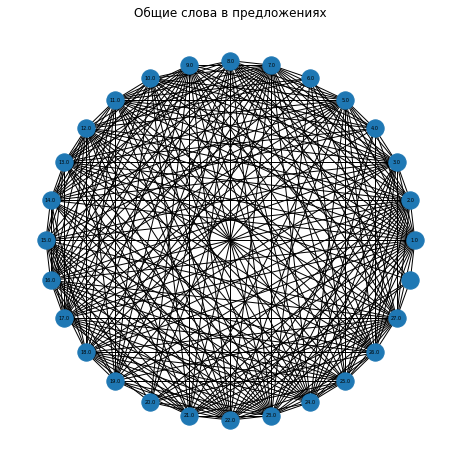

0

In [ ]:
matrix_of_edges = np.zeros((len(graph_in_matrix), len(graph_in_matrix))) # для последнего текста
for i in range(len(graph_in_matrix)):
  for j in range(len(graph_in_matrix)):
    if graph_in_matrix[i][j] != 0:
      matrix_of_edges[i][j] = 1
labels = np.arange(1, len(graph_in_matrix))
print_graph(matrix_of_edges, labels)

In [ ]:
ratin = []
for graph in dann:
  scores = [rate.mean() for rate in graph]
  rating = {i+1: scores[i] for i in range(len(scores))}
  ratin.append(rating)

In [ ]:
sorted_rate = []
for rat in ratin:
  sorted_rating = {}
  sorted_keys = sorted(rat, key=rat.get)[::-1]
  for key in sorted_keys:
    sorted_rating[key] = rat[key]
  sorted_rate.append(sorted_rating)

In [ ]:
data_test.summary[0].as_py()

'Протестующие против антикоронавирусных мер немцы скандировали имя российского президента, потому что уважают его. Такое мнение выразил депутат городской палаты представителей Гуннар Линдеманн. На этих выходных в Берлине прошли крупные акции протеста. Манифестанты требовали отменить ношение масок и отказаться от соблюдения безопасного расстояния в 1,5 м друг от друга.'

In [ ]:
# Выведем summary для текстов, равное по количеству предложений в истинном summary
sums = data_test['summary'][:10]
sum_texts = []
for text in sums:
  text = re.sub(r'\([^)]*\)', '', text.as_py())
  text = text.replace("ИИ", "искусственный интеллект")
  sum_texts.append(text.split(".")[:-1])
volume_of_summary = []
for i in range(len(sum_texts)):
  volume_of_summary.append(len(sum_texts[i]))

summaries = []
for i in range(len(new_texts)):
  best_keys = list(sorted_rate[i])[:volume_of_summary[i]] # Номера лучших предложений
  indexes_of_best_sentences = sorted(best_keys)
  summary = ''
  for index in indexes_of_best_sentences:
    summary += new_texts[i][index-1]
    summary += '.'
  summaries.append(summary)
summaries

[' По официальным данным, манифестантов было почти в два раза меньше — 18 тыс. На улице Унтер ден Линден находилась группа примерно в две тысячи человек, из которой в полицию бросали бутылки и камни. Позднее сенатор Берлина по вопросам внутренней политики Андреас Гайзель в прямом эфире Inforadio отметил, что часть полицейских была направлена именно к посольству России, из-за чего была ослаблена охрана бундестага. Всего в субботу были задержаны 316 человек.',
 ' Соглашение несет в себе надежду на создание новых мостов, которые будут способствовать деэскалации существующих конфликтов и предотвращению конфликтов в будущем», — говорится в тексте совместного заявления представителей трех стран. Поэтому, если мы посмотрим в будущем, то, в общем, отношения между арабами и Израилем, в основном, будут улучшаться». По прибытии в Абу-Даби зять президента и его советник Джаред Кушнер первым делом сообщил, что прилетел с приветствием от Дональда Трампа.',
 ' Двумя днями ранее, 30 августа, член през

### Экстрактивная суммаризация на основе обученных векторных представлений

In [ ]:
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from scipy import spatial

In [ ]:
texts = data_test['text'][:9]

In [ ]:
new_texts = []
all_w = []
for text in texts:
  all_words = re.sub(r'\([^)]*\)', '', text.as_py())
  all_words = all_words.replace("ИИ", "искусственный интеллект")
  all_words = all_words.split(".")
  all_words = all_words[:-1]
  words = []
  for sentence in all_words:
    sentence = re.sub(r'[,"\'-?:!;—%]', '', sentence)
    words.extend(sentence.split())
  all_w.append(words)
  changes = re.sub(r'\([^)]*\)', '', text.as_py())
  changes = changes.replace("ИИ", "искусственный интеллект")
  splitted_sentences = changes.split('.')
  splitted_sentences = splitted_sentences[:-1]
  sentences = []
  for sentence in splitted_sentences:
    sentence = re.sub(r'[,"\'-?:!;—%]', '', sentence)
    sentences.append(sentence.split())
  new_texts.append(sentences)

In [ ]:
unique = []
for t in all_w:
  unique_w_t = []
  for word in t:
    if word not in unique:
      unique_w_t.append(word)
  unique_w_t.sort()
  unique.append(unique_w_t)

In [ ]:
all_sentences = []
for text in new_texts:
  for sentence in text:
    all_sentences.append(sentence)

In [ ]:
model = Word2Vec(all_sentences, min_count=1, sg=1, workers=8)

In [ ]:
model.train(all_sentences, total_examples=model.corpus_count, epochs=10)

(51030, 56550)

In [ ]:
vocabulary = model.wv.vocab
print(len(vocabulary), vocabulary)

3051 {'На': <gensim.models.keyedvectors.Vocab object at 0x7f65959a8400>, 'этих': <gensim.models.keyedvectors.Vocab object at 0x7f65d4e8e640>, 'выходных': <gensim.models.keyedvectors.Vocab object at 0x7f65d4e114f0>, 'в': <gensim.models.keyedvectors.Vocab object at 0x7f65c89ee130>, 'Берлине': <gensim.models.keyedvectors.Vocab object at 0x7f65c89ee8b0>, 'прошли': <gensim.models.keyedvectors.Vocab object at 0x7f65c89ee6a0>, 'крупные': <gensim.models.keyedvectors.Vocab object at 0x7f65c89eefd0>, 'акции': <gensim.models.keyedvectors.Vocab object at 0x7f65c89eea00>, 'протеста': <gensim.models.keyedvectors.Vocab object at 0x7f65c89eee50>, 'против': <gensim.models.keyedvectors.Vocab object at 0x7f65c89ee490>, 'введенных': <gensim.models.keyedvectors.Vocab object at 0x7f65c89eeb20>, 'для': <gensim.models.keyedvectors.Vocab object at 0x7f65c89ee370>, 'борьбы': <gensim.models.keyedvectors.Vocab object at 0x7f65c89ee8e0>, 'с': <gensim.models.keyedvectors.Vocab object at 0x7f65c89eed90>, 'коронавиру

In [ ]:
word_vectors = []
for text in unique:
  w_t = []
  for word in text:
    w_t.append(model.wv[word])  
  w_t = np.array(w_t)
  word_vectors.append(w_t)
#print(word_vectors, len(word_vectors))

In [ ]:
embeddings_for_text = []
for text in word_vectors:
  words_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(text)
  words_embedded_top = words_embedded[:1000]
  embeddings_for_text.append(words_embedded_top)
print(words_embedded_top.shape)

(520, 2)


In [ ]:
X = words_embedded_top[:, 0]   # Наглядно для полседнего текста
y = words_embedded_top[:, 1]

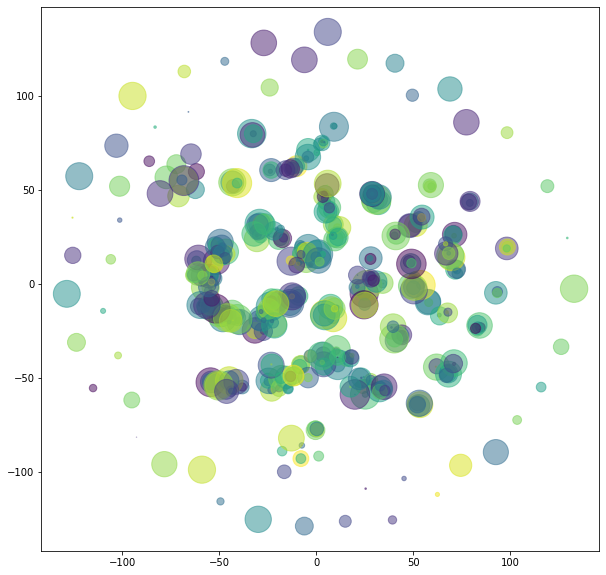

In [ ]:
colors = np.random.rand(len(words_embedded_top))
n = len(words_embedded_top)
area = (30 * np.random.rand(n))**2
plt.figure(num=1, figsize=(10, 10))
plt.scatter(X, y, s=area, c=colors, alpha=0.5)
plt.show()

In [ ]:
vectorized_texts = []
for i in range(len(new_texts)):
  vectorized_sentences = []
  for sentence in new_texts[i]:
    vectorized_sentence = []
    for word in sentence:
      if word not in vocabulary:
        vectorized_sentence.append(np.zeros(len(word_vectors[i][0])))
      else:
        vectorized_sentence.append(model.wv[word])
    vectorized_sentences.append(vectorized_sentence)
  vectorized_texts.append(vectorized_sentences)

In [ ]:
text_vectors = []
for i in range(len(vectorized_texts)):
  sentences_vectors = []
  for sentence in vectorized_texts[i]:
    sum_vectorized_words = np.zeros(len(word_vectors[i][0]))
    for word in sentence:
      sum_vectorized_words += word
    sentences_vectors.append(sum_vectorized_words / len(sentence))
  text_vectors.append(sentences_vectors)
#print(len(text_vectors), text_vectors)

In [ ]:
matrixes_t = []
for text in text_vectors:
  similarity_matrix = np.zeros((len(text), len(text)))
  matrixes_t.append(similarity_matrix)

In [ ]:
matrs = []
for t in range(len(matrixes_t)):
  for i in range(len(matrixes_t[t])):
    for j in range(len(matrixes_t[t])):
      if i < j:
        matrixes_t[t][i][j] = 1 - spatial.distance.cosine(text_vectors[t][i], text_vectors[t][j])
        matrixes_t[t][j][i] = matrixes_t[t][i][j]
  matrs.append(matrixes_t[t])

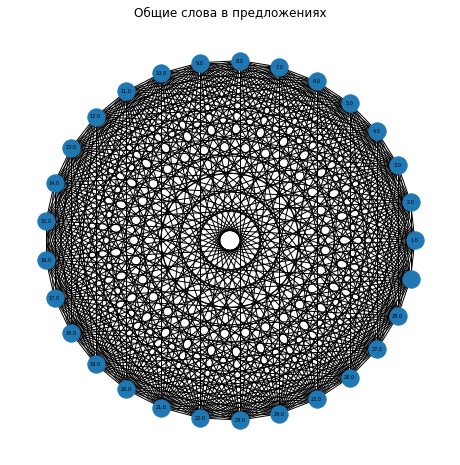

0

In [ ]:
edges_m = []                # Также для последнего текста
for matrix in matrs:
  matrix_of_edges = np.zeros((len(matrix), len(matrix)))
  for i in range(len(matrix)):
    for j in range(len(matrix)):
      if matrix[i][j] != 0:
        matrix_of_edges[i][j] = 1
  edges_m.append(matrix_of_edges)
  labels = np.arange(1, len(similarity_matrix))
print_graph(matrix_of_edges, labels)

In [ ]:
scr = []
for mat in matrs:
  scores = [rate.mean() for rate in mat]
  rating = {i+1: scores[i] for i in range(len(scores))}
  scr.append(rating)

In [ ]:
sor_rat_all = []
for rat in scr:
  sorted_rating = {}
  sorted_keys = sorted(rat, key=rat.get)[::-1]
  for key in sorted_keys:
    sorted_rating[key] = rat[key]
  sor_rat_all.append(sorted_rating)

In [ ]:
# Выведем summary для текстов, равное по количеству предложений в истинном summary
sums = data_test['summary'][:10]
sum_texts = []
for text in sums:
  text = re.sub(r'\([^)]*\)', '', text.as_py())
  text = text.replace("ИИ", "искусственный интеллект")
  sum_texts.append(text.split(".")[:-1])
volume_of_summary = []
for i in range(len(sum_texts)):
  volume_of_summary.append(len(sum_texts[i]))

new_texts = []
for text in texts:
  text = re.sub(r'\([^)]*\)', '', text.as_py())
  text = text.replace("ИИ", "искусственный интеллект")
  new_texts.append(text.split("."))

summaries = []
for i in range(len(new_texts)):
  best_keys = list(sor_rat_all[i])[:volume_of_summary[i]] # Номера лучших предложений
  indexes_of_best_sentences = sorted(best_keys)
  summary = ''
  for index in indexes_of_best_sentences:
    summary += new_texts[i][index-1]
    summary += '.'
  summaries.append(summary)
summaries

[' Стали известны случаи чрезмерного насилия со стороны полиции, с которыми мы будем разбираться на парламентском уровне в берлинской палате представителей», — отметил он. В эти выходные — 29 и 30 августа — в Берлине прошли массовые акции протеста против антикоронавирусных мер: ношения масок и соблюдения безопасного расстояния в 1,5 м друг от друга. В частности, было перекрыто пространство вокруг Бранденбургских ворот, а также Александерплац и Лейпцигерплац. Но на улице Унтер-ден-Линден, почти перед российским посольством были насильственные действия, там кидали бутылки и камни, были раненые, задержано более 200 человек — там было необходимо полицейское подкрепление, и произошла переброска сил.',
 ' Именно с подачи президента США Дональда Трампа Израиль начал двигаться в этом направлении — 28 января президент США представил свою «сделку века», подразумевающую не только аннексию территорий, но и признание Иерусалима неразделимой столицей Израиля. Значимым стал тот факт, что самолет прол

In [ ]:
data_test.summary[8].as_py()

'Российский истребитель Су-27 не нарушал границ Дании во время перехвата американского стратегического бомбардировщика В-52Н, заявили в Минобороны. Об этом инциденте сообщалось накануне, когда самолет США летел в сторону датского острова Борнхольм. В последнее время подобные вылеты на перехват российских самолетов происходят все чаще.'

## Абстрактивная суммаризация

In [ ]:
# Текстовая суммаризация с использованием lstm и attention layer
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Создаем обучаемую переменную веса для слоя

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Вычисление hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Функция шага для вычисления ci, используя ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Вычисляем выводы energy """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Вычисляем контекстные векторы """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Выводы слоя """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from tensorflow.keras.utils import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
data = data_test.copy()

In [ ]:
data.drop_duplicates(subset=['text'],inplace=True)  # удаление лубликатов
data.dropna(axis=0,inplace=True)  # удаление пропусков (nan)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6793 entries, 0 to 6792
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     6793 non-null   object
 1   summary  6793 non-null   object
 2   title    6793 non-null   object
 3   date     6793 non-null   object
 4   url      6793 non-null   object
dtypes: object(5)
memory usage: 318.4+ KB


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('russian')) 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def text_cleaner(text,num):
    text = text.as_py()
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^а-яА-Я]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 # удаление коротких слов
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
cleaned_text = []
for t in data['text']:
    cleaned_text.append(text_cleaner(t,0))
cleaned_text[:5]  

['этих выходных берлине прошли крупные акции протеста против введенных борьбы коронавирусом ограничений демонстранты скандировали путин словам депутата городской палаты представителей гуннара линдеманна люди выкрикивали фамилию российского президента уважения нему комментарии риа новости немецкий политик отметил среди населения германии владимир путин имеет хорошую репутацию мнению протестующие ранее пришли российскому посольству привлечь внимание условиям германии надеясь россия сможет оказать влияние канцлера фрг ангелу меркель взгляд опасности посольства россии возникло разу сказал депутат несмотря протест оказался массовым выступления носили преимущественно мирный характер уверен линдеманн словам исключением стала ситуацию немецкого парламента несколько странных участников демонстрации попытались штурмовать бундестаг знак протеста против правительства считает политик реальной опасности полиция реагировала соразмерно стали известны случаи чрезмерного насилия стороны полиции которыми

In [ ]:
cleaned_summary = []
for t in data['summary']:
    cleaned_summary.append(text_cleaner(t,1))
cleaned_summary[:10]

['протестующие против антикоронавирусных мер немцы скандировали имя российского президента потому что уважают его такое мнение выразил депутат городской палаты представителей гуннар линдеманн на этих выходных берлине прошли крупные акции протеста манифестанты требовали отменить ношение масок отказаться от соблюдения безопасного расстояния друг от друга',
 'делегации израиля сша прилетели оаэ где обсудили руководством страны ряд вопросов преддверии подписания соглашений сотрудничестве гражданских экономических сферах рейс на котором они прибыли стал первым прямым перелетом из тель авива контакты сторон проходят рамках подписания соглашения нормализации отношений посредником подписании которого стали сша которые всячески подчеркивают свое участие для получения политических очков дональдом трампом',
 'белорусская оппозиция лице экс кандидата президенты рб виктора бабарико координатора его штаба марии колесниковой объявила создании политической партии вместе по словам бабарико задержанного

In [ ]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [ ]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

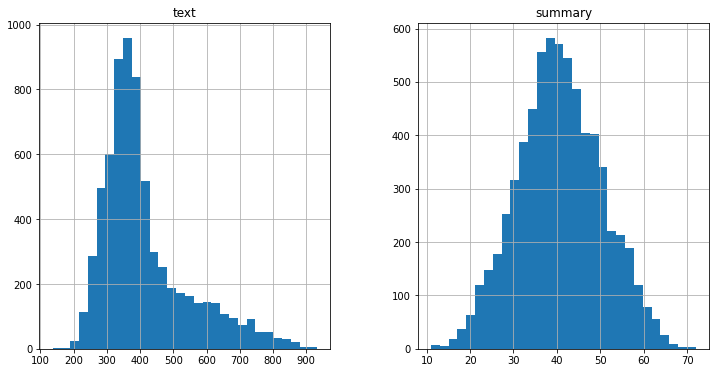

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# заполняем массивы длинами предложений
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

fig = plt.figure(figsize=(12, 6))
ax = fig.gca()
length_df.hist(bins = 30, ax=ax)
plt.show()

In [ ]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=60):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9823347563668482


In [ ]:
cnt=0
for i in data['cleaned_text']:
    if(len(i.split())<=800):
        cnt=cnt+1
print(cnt/len(data['cleaned_text']))

0.9863094361843073


In [ ]:
max_text_len=800
max_summary_len=60

In [ ]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
for i in range(5):
    print("Статья:",df['text'][i])
    print("Резюме:",df['summary'][i])
    print("\n")

Статья: этих выходных берлине прошли крупные акции протеста против введенных борьбы коронавирусом ограничений демонстранты скандировали путин словам депутата городской палаты представителей гуннара линдеманна люди выкрикивали фамилию российского президента уважения нему комментарии риа новости немецкий политик отметил среди населения германии владимир путин имеет хорошую репутацию мнению протестующие ранее пришли российскому посольству привлечь внимание условиям германии надеясь россия сможет оказать влияние канцлера фрг ангелу меркель взгляд опасности посольства россии возникло разу сказал депутат несмотря протест оказался массовым выступления носили преимущественно мирный характер уверен линдеманн словам исключением стала ситуацию немецкого парламента несколько странных участников демонстрации попытались штурмовать бундестаг знак протеста против правительства считает политик реальной опасности полиция реагировала соразмерно стали известны случаи чрезмерного насилия стороны полиции ко

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.05,random_state=0,shuffle=True) 

In [ ]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% редких слов в словаре:",(cnt/tot_cnt)*100)
print("Общий процент редких слов:",(freq/tot_freq)*100)

% редких слов в словаре: 64.09975130735046
Общий процент редких слов: 6.011213311122937


In [ ]:
# подготовка токенайзера для статей на тренировочных данных
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# конвертация последовательностей предложений в последовательности целых чисел
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# заполнение от нуля до максимальной длины
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# размер словаря
x_voc = x_tokenizer.num_words + 1

print("Размер словаря X = {}".format(x_voc))

Размер словаря X = 57599


In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% редких слов в словаре:",(cnt/tot_cnt)*100)
print("Общий процент редких слов:",(freq/tot_freq)*100)

% редких слов в словаре: 84.87719537409401
Общий процент редких слов: 23.37616703253522


In [ ]:
# подготовка токенайзера для резюме на тренировочных данных
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# конвертация последовательностей предложений в последовательности целых чисел
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# заполнение от нуля до максимальной длины
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# размер словаря
y_voc = y_tokenizer.num_words +1
print("Размер словаря Y = {}".format(y_voc))

Размер словаря Y = 6657


In [ ]:
%pdb off

Automatic pdb calling has been turned OFF


In [ ]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(6258, 6258)

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 800, 100)     5759900     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 800, 300),   481200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = [EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2), 
      ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/MyModel_tf',monitor='val_loss', verbose=1,
                      save_best_only=True, mode='min', save_weights_only = False)]

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=7,callbacks=[es],batch_size=32, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/7
196/196 [==============================] - ETA: 0s - loss: 4.2807 
Epoch 1: val_loss improved from inf to 3.76650, saving model to /content/drive/MyDrive/Colab Notebooks/MyModel_tf
196/196 [==============================] - 2589s 13s/step - loss: 4.2807 - val_loss: 3.7665
Epoch 2/7
196/196 [==============================] - ETA: 0s - loss: 4.0093 
Epoch 2: val_loss improved from 3.76650 to 3.74183, saving model to /content/drive/MyDrive/Colab Notebooks/MyModel_tf
196/196 [==============================] - 2450s 13s/step - loss: 4.0093 - val_loss: 3.7418
Epoch 3/7
196/196 [==============================] - ETA: 0s - loss: 3.9919 
Epoch 3: val_loss improved from 3.74183 to 3.73334, saving model to /content/drive/MyDrive/Colab Notebooks/MyModel_tf
196/196 [==============================] - 2406s 12s/step - loss: 3.9919 - val_loss: 3.7333
Epoch 4/7
196/196 [==============================] - ETA: 0s - loss: 3.9856 
Epoch 4: val_loss improved from 3.73334 to 3.72776, saving model t

In [ ]:
# визуализация модели
from tensorflow.keras.utils import plot_model
plot_model(model,'model.png',show_shapes=True,dpi=100)

NameError: ignored

In [ ]:
# записать модель в json
model_json = model.to_json()
with open("summary.json", "w") as json_file:
    json_file.write(model_json)
# записать веса в HDF5
model.save_weights("summary.h5")
print("Model saved")

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,100):
    print("Статья:",seq2text(x_tr[i]))
    print("Оригинальное резюме:",seq2summary(y_tr[i]))
    print("Предсказанное резюме:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")